### **Homework 3**
Apply the following steps to the dataset you created in Homework 1 (some of these steps
were already done in previous exercises):
1. Use the corpus you created in Homework 1 and 2, after performing tokenization,
lemmatization, normalization, stop-word removal, and word vectorization.
2. Apply RNN model to predict the probability of the next word in a sentence.
3. Apply a Long Short-Term Memory (LSTM) model to predict the probability of the next
word in a sentence.
4. Compare the results of the RNN and LSTM models in terms of their predictive
performance (e.g., perplexity, accuracy) for the next-word prediction task.
5. Use the KL-Sum algorithm (or any other relevant summarization algorithm) to perform
extractive text summarization on the corpus.
6. Fine-tune a pre-trained GPT-2 language model on your corpus. Select 5 partial sentences
from the corpus, and use the fine-tuned GPT-2 model to generate completions for those
partial sentences.
7. Apply sentiment analysis techniques (e.g., a pre-trained sentiment analysis model or a
rule-based approach) to the corpus, and report the statistics of the sentiment distribution
(e.g., percentage of positive, negative, and neutral sentences) in your text.

**The corpus I created in homework 1-2:**

### **Imports**

In [ ]:
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords, words
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, WhitespaceTokenizer

import pandas as pd
from google.colab import drive

### **Loading the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Data/spam.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download nltk resources if not already present
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv(path, encoding='latin-1')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Basic preprocessing
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
wordnet_lemmatizer = WordNetLemmatizer()

### **Relevant Functions**

In [ ]:
# Tokenization
def whitespace_tokenizer(text):
    tokenizer = WhitespaceTokenizer()
    return tokenizer.tokenize(text)

def regex_tokenizer(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

def word_tokenizer(text):
    return word_tokenize(text)

def sentence_tokenizer(text):
    return sent_tokenize(text)

# Normalization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

def lemmatization(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Remove stop words
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

In [ ]:
# Process the corpus
corpus = df['v2'].tolist()
# Initialize the processed corpus list
final_processed_corpus = []

# Define the processing function
def process_text(text):
    # Step 1: Tokenization
    whitespace_tokens = whitespace_tokenizer(text)
    regex_tokens = regex_tokenizer(text)
    word_tokens = word_tokenizer(text)
    sentence_tokens = sentence_tokenizer(text)

    # Step 2: Normalization - Stemming and Lemmatization
    stemmed_tokens = stemming(word_tokens)
    lemmatized_tokens = lemmatization(word_tokens)

    # Step 3: Stop Words Removal
    stopword_removed_tokens = remove_stopwords(word_tokens)

    # Combine all transformations into a single representation
    combined_tokens = {
        'whitespace_tokens': whitespace_tokens,
        'regex_tokens': regex_tokens,
        'word_tokens': word_tokens,
        'sentence_tokens': sentence_tokens,
        'stemmed_tokens': stemmed_tokens,
        'lemmatized_tokens': lemmatized_tokens,
        'stopword_removed_tokens': stopword_removed_tokens
    }

    return combined_tokens

# Process each text in the corpus
for text in corpus:
    processed_text = process_text(text)
    final_processed_corpus.append(processed_text)


### **word vectorization**

In [ ]:
def word2vec_extraction(tokens):
    model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    return model

In [ ]:
# Combine all tokens from the processed corpus for word2vec training
all_tokens = [tokens['word_tokens'] for tokens in final_processed_corpus]
word2vec_model = word2vec_extraction(all_tokens)

### **Apply RNN model to predict the probability of the next word in a sentence**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Prepare the data - Use the lemmatized tokens from your processed corpus
sentences = [' '.join(tokens['lemmatized_tokens']) for tokens in final_processed_corpus]

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length))
rnn_model.add(SimpleRNN(16))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
labels = np.array([1] * (len(sentences) // 2) + [0] * (len(sentences) - len(sentences) // 2))

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
126/126 [==============================] - 8s 43ms/step - loss: 0.6941 - accuracy: 0.4877 - val_loss: 0.6956 - val_accuracy: 0.4731
Epoch 2/50
126/126 [==============================] - 5s 41ms/step - loss: 0.6948 - accuracy: 0.5101 - val_loss: 0.6929 - val_accuracy: 0.5112
Epoch 3/50
126/126 [==============================] - 7s 57ms/step - loss: 0.6938 - accuracy: 0.5001 - val_loss: 0.6917 - val_accuracy: 0.5269
Epoch 4/50
126/126 [==============================] - 5s 41ms/step - loss: 0.6914 - accuracy: 0.5223 - val_loss: 0.6920 - val_accuracy: 0.5135
Epoch 5/50
126/126 [==============================] - 7s 58ms/step - loss: 0.6848 - accuracy: 0.5644 - val_loss: 0.7127 - val_accuracy: 0.4888
Epoch 6/50
126/126 [==============================] - 5s 39ms/step - loss: 0.6644 - accuracy: 0.6086 - val_loss: 0.7156 - val_accuracy: 0.5067
Epoch 7/50
126/126 [==============================] - 6s 45ms/step - loss: 0.6269 - accuracy: 0.6687 - val_loss: 0.7523 - val_accuracy: 0.4888

### **Apply a Long Short-Term Memory (LSTM) model to predict the probability of the next word in a sentence**

In [ ]:
# Prepare the data - Use the lemmatized tokens from your processed corpus
sentences = [' '.join(tokens['lemmatized_tokens']) for tokens in final_processed_corpus]

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Create the model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length))
lstm_model.add(LSTM(16))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create labels (assuming first half is positive, second half is negative)
labels = np.array([1] * (len(sentences) // 2) + [0] * (len(sentences) - len(sentences) // 2))

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
126/126 [==============================] - 16s 99ms/step - loss: 0.6935 - accuracy: 0.4931 - val_loss: 0.6929 - val_accuracy: 0.5269
Epoch 2/50
126/126 [==============================] - 8s 65ms/step - loss: 0.6934 - accuracy: 0.5031 - val_loss: 0.6923 - val_accuracy: 0.5269
Epoch 3/50
126/126 [==============================] - 10s 79ms/step - loss: 0.6935 - accuracy: 0.4996 - val_loss: 0.6928 - val_accuracy: 0.5269
Epoch 4/50
126/126 [==============================] - 10s 82ms/step - loss: 0.6934 - accuracy: 0.4944 - val_loss: 0.6934 - val_accuracy: 0.4731
Epoch 5/50
126/126 [==============================] - 8s 65ms/step - loss: 0.6933 - accuracy: 0.4887 - val_loss: 0.6928 - val_accuracy: 0.5269
Epoch 6/50
126/126 [==============================] - 10s 82ms/step - loss: 0.6933 - accuracy: 0.4877 - val_loss: 0.6931 - val_accuracy: 0.5269
Epoch 7/50
126/126 [==============================] - 10s 81ms/step - loss: 0.6933 - accuracy: 0.4984 - val_loss: 0.6937 - val_accuracy: 0

### **Compare the results of the RNN and LSTM models in terms of their predictive performance (e.g., perplexity, accuracy) for the next-word prediction task**

RNN Results:
Accuracy: 0.4960
Perplexity: 7.0754

LSTM Results:
Accuracy: 0.4915
Perplexity: 2.0000


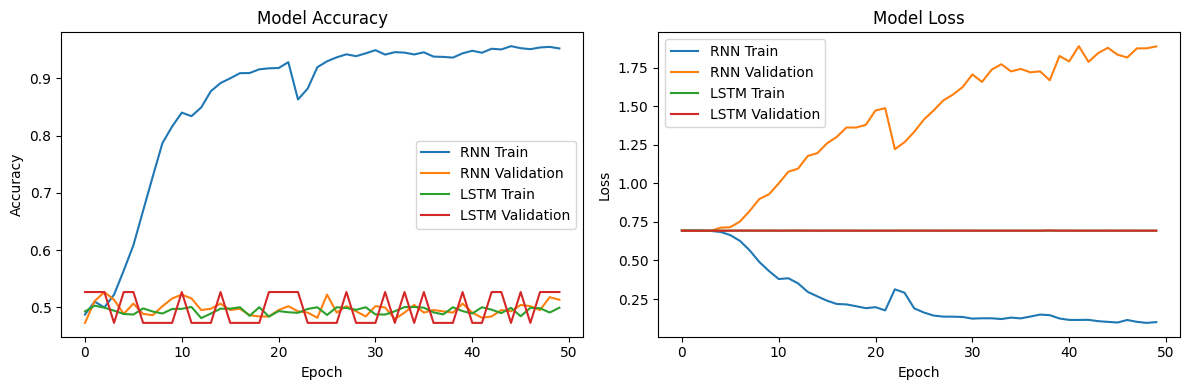

In [ ]:
from sklearn.model_selection import train_test_split

# Evaluate models
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    perplexity = np.exp(loss)
    return accuracy, perplexity

rnn_accuracy, rnn_perplexity = evaluate_model(rnn_model, X_test, y_test)
lstm_accuracy, lstm_perplexity = evaluate_model(lstm_model, X_test, y_test)

print("RNN Results:")
print(f"Accuracy: {rnn_accuracy:.4f}")
print(f"Perplexity: {rnn_perplexity:.4f}")

print("\nLSTM Results:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"Perplexity: {lstm_perplexity:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Train')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='RNN Train')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation')
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### **Use the KL-Sum algorithm (or any other relevant summarization algorithm) to perform extractive text summarization on the corpus**

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import kl_div

def kl_sum(sentences, num_sentences=3):
    # Create a CountVectorizer to get word frequencies
    vectorizer = CountVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)

    # Get word frequencies for the entire text
    text_freq = np.sum(sentence_vectors, axis=0)
    text_freq = text_freq / np.sum(text_freq)

    # Initialize summary with the first sentence
    summary = [0]
    summary_freq = sentence_vectors[0].toarray().flatten()
    summary_freq = summary_freq / np.sum(summary_freq)

    # Select sentences to minimize KL divergence
    while len(summary) < num_sentences:
        min_kl = float('inf')
        min_idx = -1

        for i in range(len(sentences)):
            if i not in summary:
                # Calculate new summary frequency if we add this sentence
                new_summary_freq = summary_freq + sentence_vectors[i].toarray().flatten()
                new_summary_freq = new_summary_freq / np.sum(new_summary_freq)

                # Calculate KL divergence
                kl = np.sum(kl_div(text_freq, new_summary_freq))

                if kl < min_kl:
                    min_kl = kl
                    min_idx = i

        # Add the sentence that minimizes KL divergence
        summary.append(min_idx)
        summary_freq = summary_freq + sentence_vectors[min_idx].toarray().flatten()
        summary_freq = summary_freq / np.sum(summary_freq)

    return [sentences[i] for i in sorted(summary)]

# Use the corpus you've already processed
corpus = df['v2'].tolist()

# Perform summarization on each text in the corpus
summarized_corpus = []
for text in corpus:
    sentences = sent_tokenize(text)
    if len(sentences) > 3:  # Only summarize if there are more than 3 sentences
        summary = kl_sum(sentences)
        summarized_corpus.append(' '.join(summary))
    else:
        summarized_corpus.append(text)  # Keep original text if it's short

# Print a few examples
for i in range(5):
    print(f"Original text: {corpus[i]}")
    print(f"Summarized text: {summarized_corpus[i]}")
    print()

# Calculate average reduction in text length
original_lengths = [len(text.split()) for text in corpus]
summary_lengths = [len(text.split()) for text in summarized_corpus]
avg_reduction = 1 - (sum(summary_lengths) / sum(original_lengths))
print(f"Average text length reduction: {avg_reduction:.2%}")

<ipython-input-41-52a7c6c1ccb0>:17: RuntimeWarning: invalid value encountered in divide
  summary_freq = summary_freq / np.sum(summary_freq)
<ipython-input-41-52a7c6c1ccb0>:17: RuntimeWarning: divide by zero encountered in divide
  summary_freq = summary_freq / np.sum(summary_freq)


Original text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Summarized text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Original text: Ok lar... Joking wif u oni...
Summarized text: Ok lar... Joking wif u oni...

Original text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Summarized text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Original text: U dun say so early hor... U c already then say...
Summarized text: U dun say so early hor... U c already then say...

Original text: Nah I don't think he goes to usf, he lives around here though
Summarized text: Nah I don't think he goes to usf, he lives around here though

Average text le

### **Fine-tune a pre-trained GPT-2 language model on your corpus. Select 5 partial sentences from the corpus, and use the fine-tuned GPT-2 model to generate completions for those partial sentences**

In [ ]:
!pip install transformers torch
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import random

# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Prepare the dataset
def prepare_dataset(texts, tokenizer):
    # Join all texts into a single string
    full_text = " ".join(texts)

    # Encode the text
    encodings = tokenizer(full_text, truncation=True, max_length=512)

    # Create a dataset
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path="corpus.txt",  # We'll save the corpus to a file
        block_size=128
    )

    return dataset

# Save corpus to a file
with open("corpus.txt", "w", encoding="utf-8") as f:
    for text in corpus:
        f.write(text + "\n")

# Prepare the dataset
dataset = prepare_dataset(corpus, tokenizer)

# Prepare data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./gpt2-finetuned")
tokenizer.save_pretrained("./gpt2-finetuned")

# Function to generate completions
def generate_completion(prompt, model, tokenizer, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, temperature=0.7)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Select 5 partial sentences from the corpus
partial_sentences = []
for _ in range(5):
    text = random.choice(corpus)
    words = text.split()
    if len(words) > 5:
        partial = " ".join(words[:len(words)//2])
        partial_sentences.append(partial)

# Generate completions
for partial in partial_sentences:
    completion = generate_completion(partial, model, tokenizer)
    print(f"Partial: {partial}")
    print(f"Completion: {completion}")
    print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


NameError: name 'corpus' is not defined